# Failure prediction of FPSO's equipment
**Author:** Matheus Bom

**E-mail:** matbom95@gmail.com

**GitHub:** https://github.com/MatBom

**LinkedIn:** https://www.linkedin.com/in/matheus-bom

# About the business case

This business case is based on a real-world scenario involving the operation of an FPSO (Floating Production, Storage, and Offloading) vessel. The focus is on identifying patterns that may indicate an imminent failure in one of the onboard machines. FPSOs rely on a wide array of sensors and instrumentation to monitor and control equipment performance across various configurations and time periods. The challenge consists of analyzing historical time series data from one specific piece of equipment in different operating cycles, with the objective of identifying sensor behaviors and parameters that may serve as early warning signs of equipment failure.

The dataset provided contains anonymized operational records collected over time from this equipment. These records include multiple sensor readings that capture key physical and operational parameters, offering a foundation for developing data-driven insights into machine reliability and predictive maintenance opportunities.

# Exploratory Data analysis

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('Test O_G_Equipment_Data.xlsx')

## Data Dictionary
**Cycle:** Sequential order of measurement cycles (appropriate for time-series analysis).

**Preset:** Specific equipment configuration, Preset 1 has 3 settings, while Preset 2 has 8.

**Temperature:** Temperature recorded in the equipment.

**Vibrations (X, Y, Z):** Vibrations along the machine's axes, with 3 degrees of freedom.

**Frequency:** Operating frequency of the machine (indicates how fast the equipment is running during each cycle).

**Fail:** Target variable indicating whether the machine has failed.

In [3]:
df.head()

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Cycle        800 non-null    int64  
 1   Preset_1     800 non-null    int64  
 2   Preset_2     800 non-null    int64  
 3   Temperature  800 non-null    float64
 4   Pressure     800 non-null    float64
 5   VibrationX   800 non-null    float64
 6   VibrationY   800 non-null    float64
 7   VibrationZ   800 non-null    float64
 8   Frequency    800 non-null    float64
 9   Fail         800 non-null    bool   
 10  Preset       800 non-null    object 
dtypes: bool(1), float64(6), int64(3), object(1)
memory usage: 63.4+ KB


The dataset is complete, with no missing values, ideal to start the exploratory analysis.

## 1. How many times the equipment has failed

First, it is necessary to observe how failures behave to check if there are any insights to be gained from the data or any business complexity (such as the machine failing consecutively for several cycles).

Number of times the equipment has failed: 66 out of 800 cycles (failure rate of 8.25%)


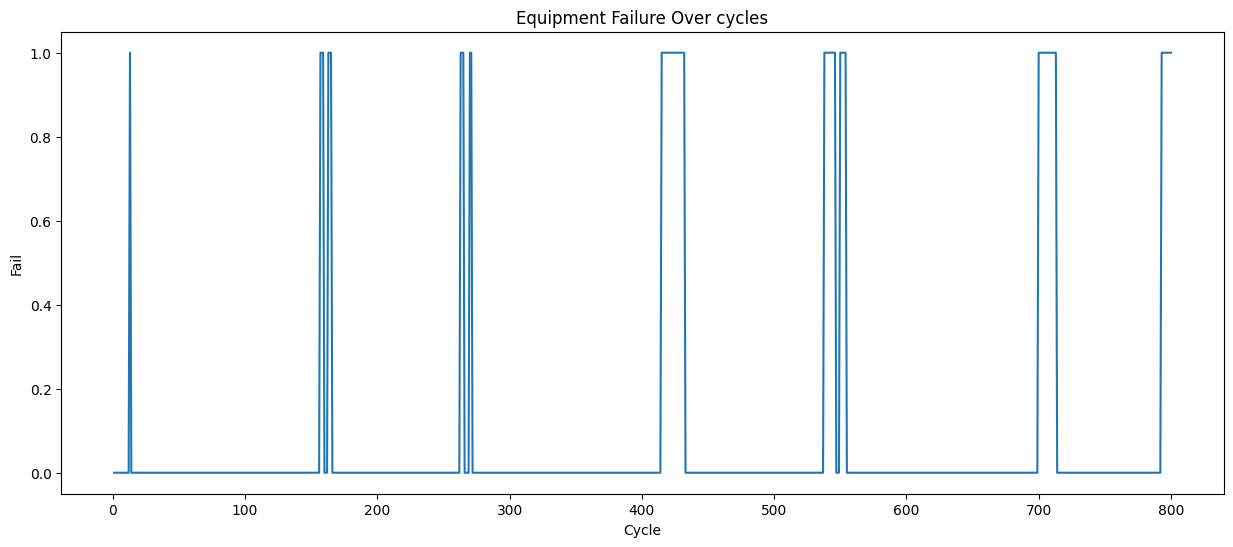

In [50]:
print(f'Number of times the equipment has failed: {df["Fail"].sum()} out of {df["Cycle"].count()} cycles (failure rate of {df["Fail"].mean() * 100:.2f}%)')

plt.figure(figsize=(15, 6))
sns.lineplot(data = df, x = 'Cycle', y = 'Fail')
plt.title('Equipment Failure Over cycles')
plt.show()

The machine appears to have well-spaced failures, but it is observed that not only are there sequential cycles of failures, there are also moments when a failure occurs quickly after the previous failure has recovered. This behavior may require future feature engineering.

Total failures in window: 18
Failure window starts at cycle 415 and ends at cycle 432


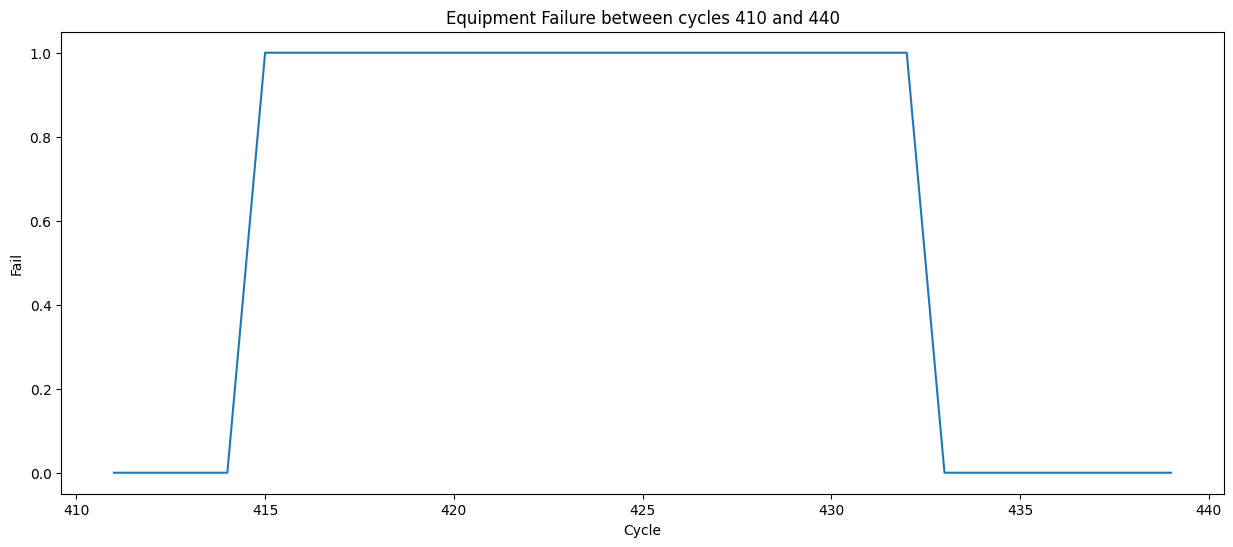

In [67]:
# Filter the window where failures occurred between cycles 410 and 440
window_df = df[(df['Cycle'] > 410) & (df['Cycle'] < 440) & (df['Fail'])]

# Show summary statistics for the failure window
print(f'Total failures in window: {window_df.shape[0]}')
print(f'Failure window starts at cycle {window_df["Cycle"].min()} and ends at cycle {window_df["Cycle"].max()}')


plt.figure(figsize=(15, 6))
sns.lineplot(data = df[(df['Cycle'] > 410) & (df['Cycle'] < 440)], x = 'Cycle', y = 'Fail')
plt.title('Equipment Failure between cycles 410 and 440')
plt.show()

Overall, **the equipment failed 66 out of 800 cycles**, with a failure rate of 8.25%. A closer look at the biggest failure window tell us that **a failure state can last up to 18 cycles**.

## 2. Equipment failures by setup configurations

I will check whether all configuration combinations are being used uniformly, or if there is an unbalanced use of the configurations. Additionally, I will observe the equipment failure proportion for each configuration pair to identify any strong association between configuration and failure.

In [ ]:
# Just checking the available presets
print(f'Available settings in preset_1: {df["Preset_1"].sort_values().unique()}')
print(f'Available settings in preset_2: {df["Preset_2"].sort_values().unique()}')

Available settings in preset_1: [1 2 3]
Available settings in preset_2: [1 2 3 4 5 6 7 8]


I will be treating preset as **a categorical variable**. In order to measure association between preset and failure, it will be used Cramér's V, a measure based on Pearson's chi-square test.

In [82]:
from scipy.stats import chi2_contingency

confusion_matrix = pd.crosstab(df['Preset_1'], df['Fail'])
chi2 = chi2_contingency(confusion_matrix)[0]
n = confusion_matrix.sum().sum()
r, k = confusion_matrix.shape
print(f'The association between preset 1 and failure is: {np.sqrt(chi2 / (n * (min(r, k) - 1))):.3f}')

# Checking if Preset 1 is being used uniformly and has a strong association with failure
grouped = df.groupby(['Preset_1'])
result = grouped['Fail'].agg(
    count='size',
    fail_count = lambda x: (x == True).sum(),
    fail_proportion=lambda x: (x == True).mean()
).reset_index().sort_values('fail_proportion', ascending=False)
print(result)

The association between preset 1 and failure is: 0.051
   Preset_1  count  fail_count  fail_proportion
0         1    264          27         0.102273
1         2    281          21         0.074733
2         3    255          18         0.070588


The association of 0.051 implies in a **weak association** between Preset 1 and fail

In [81]:
confusion_matrix = pd.crosstab(df['Preset_2'], df['Fail'])
chi2 = chi2_contingency(confusion_matrix)[0]
n = confusion_matrix.sum().sum()
r, k = confusion_matrix.shape
print(f'The association between preset 2 and failure is: {np.sqrt(chi2 / (n * (min(r, k) - 1))):.3f}')

# Checking if Preset 2 is being used uniformly and has a strong association with failure
grouped = df.groupby(['Preset_2'])
result = grouped['Fail'].agg(
    count='size',
    fail_count = lambda x: (x == True).sum(),
    fail_proportion=lambda x: (x == True).mean()
).reset_index().sort_values('fail_proportion', ascending=False)
result

The association between preset 2 and failure is: 0.096


,Preset_2,count,fail_count,fail_proportion
4,5,100,12,0.120000
0,1,95,11,0.115789
1,2,101,9,0.089109
5,6,101,9,0.089109
6,7,109,9,0.082569
7,8,100,7,0.070000
2,3,101,6,0.059406
3,4,93,3,0.032258


The association of 0.096 for preset 2 is slightly stronger, but overall still a **weak association**.

In [239]:
# Combining both presets into one single feature
df['Preset'] = df['Preset_1'].astype(str) + '-' + df['Preset_2'].astype(str)

confusion_matrix = pd.crosstab(df['Preset'], df['Fail'])
chi2 = chi2_contingency(confusion_matrix)[0]
n = confusion_matrix.sum().sum()
r, k = confusion_matrix.shape
print(f'The association between both presets and failure is: {np.sqrt(chi2 / (n * (min(r, k) - 1))):.3f}')

# Checking whether both Presets are being used uniformly and if there is a strong correlation with failure
grouped = df.groupby(['Preset'])
result = grouped['Fail'].agg(
    count='size',
    fail_count = lambda x: (x == True).sum(),
    fail_proportion=lambda x: (x == True).mean()
).reset_index().sort_values('fail_proportion', ascending=False)
result

The association between both presets and failure is: 0.138


,Preset,count,fail_count,fail_proportion
4,1-5,31,5,0.161290
20,3-5,29,4,0.137931
8,2-1,30,4,0.133333
1,1-2,38,5,0.131579
0,1-1,34,4,0.117647
15,2-8,37,4,0.108108
6,1-7,38,4,0.105263
21,3-6,30,3,0.100000
16,3-1,31,3,0.096774
3,1-4,22,2,0.090909


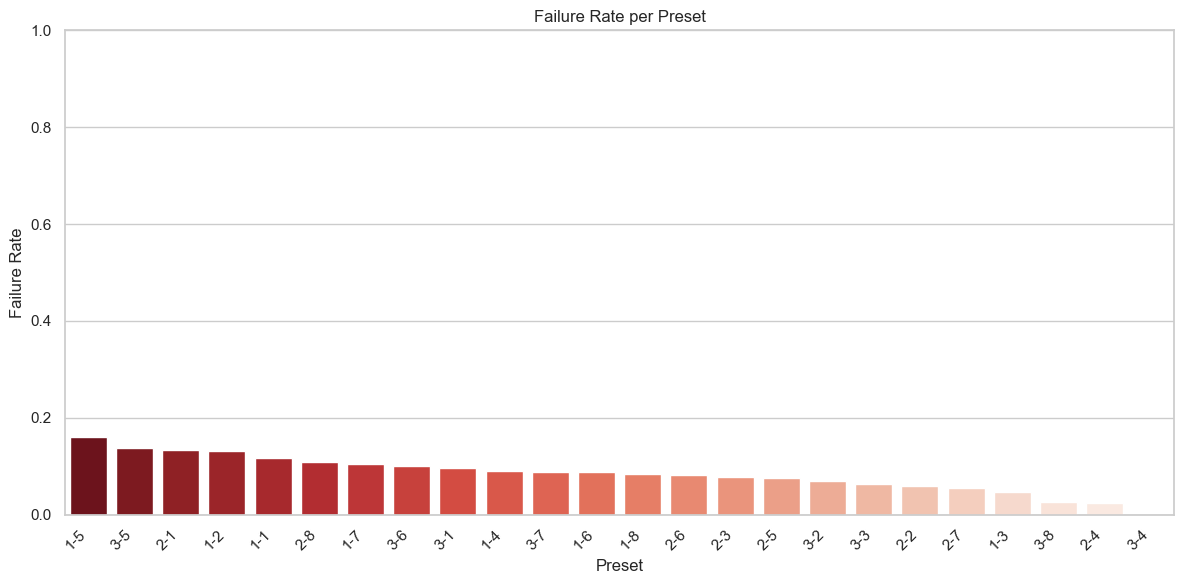

In [258]:
# Failure rate per preset barplot
result = result.sort_values('fail_proportion', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=result,
    x='Preset',
    y='fail_proportion',
    palette='Reds_r'
)

plt.title('Failure Rate per Preset')
plt.ylabel('Failure Rate')
plt.xlabel('Preset')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

The combination of presets 1 and 2 resulted in **a weak association of 0.138**, altough it was a little bit stronger than the association of presets 1 and 2 watched separately. Which means that while neither preset alone shows a strong link to failure, certain combinations may slightly increase the likelihood of failure. This suggests that **presets may have a predictive power**, but it remains limited.

## 3. Equipment failures by readings

The goal here is to confirm whether failures occur when observing high readings from features, and also whether failures stop occurring when only one high reading is made while the others remain at normal levels.

Also, the vibration reading was provided as a decomposed vector, so its magnitude (module) can serve as a useful feature for the model. However, the magnitude only represents the intensity of the vibration, without any directional information. It is still important to investigate whether failures can be caused by vibration along a specific axis, which could indicate a potential issue with the equipment's strength or design.

In [122]:
df["Vibration"] = np.sqrt(df["VibrationX"]**2 + df["VibrationY"]**2 + df["VibrationZ"]**2)

<Axes: title={'center': 'Vibration (module)'}, xlabel='Vibration', ylabel='Count'>

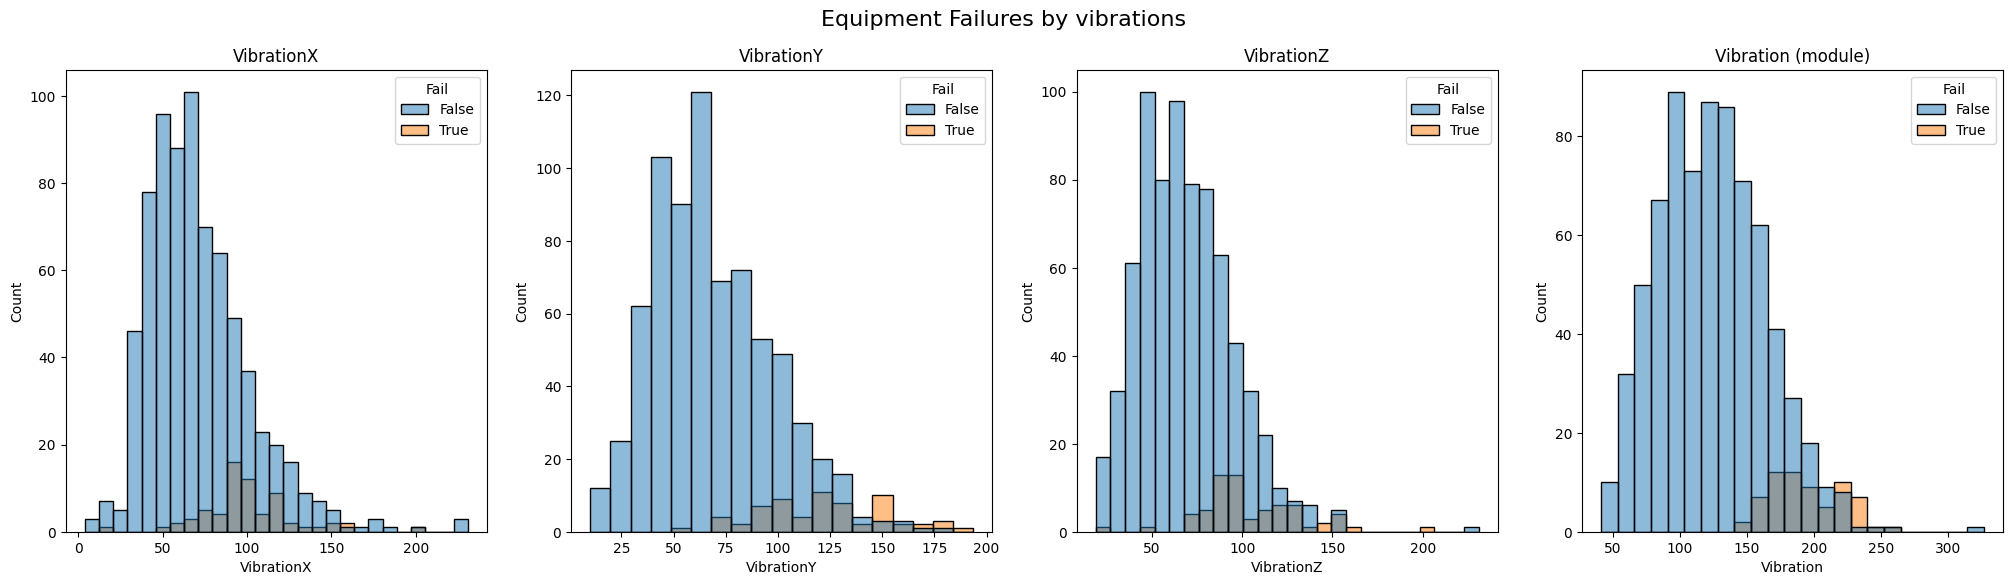

In [245]:
figure, axes = plt.subplots(1, 4,figsize=(25, 6))
figure.suptitle('Equipment Failures by vibrations', fontsize=16)
axes[0].set_title('VibrationX')
axes[1].set_title('VibrationY')
axes[2].set_title('VibrationZ')
axes[3].set_title('Vibration (module)')

sns.histplot(data = df, x = 'VibrationX', hue = 'Fail', ax = axes[0])
sns.histplot(data = df, x = 'VibrationY', hue = 'Fail', ax = axes[1])
sns.histplot(data = df, x = 'VibrationZ', hue = 'Fail', ax = axes[2])
sns.histplot(data = df, x = 'Vibration', hue = 'Fail', ax = axes[3])

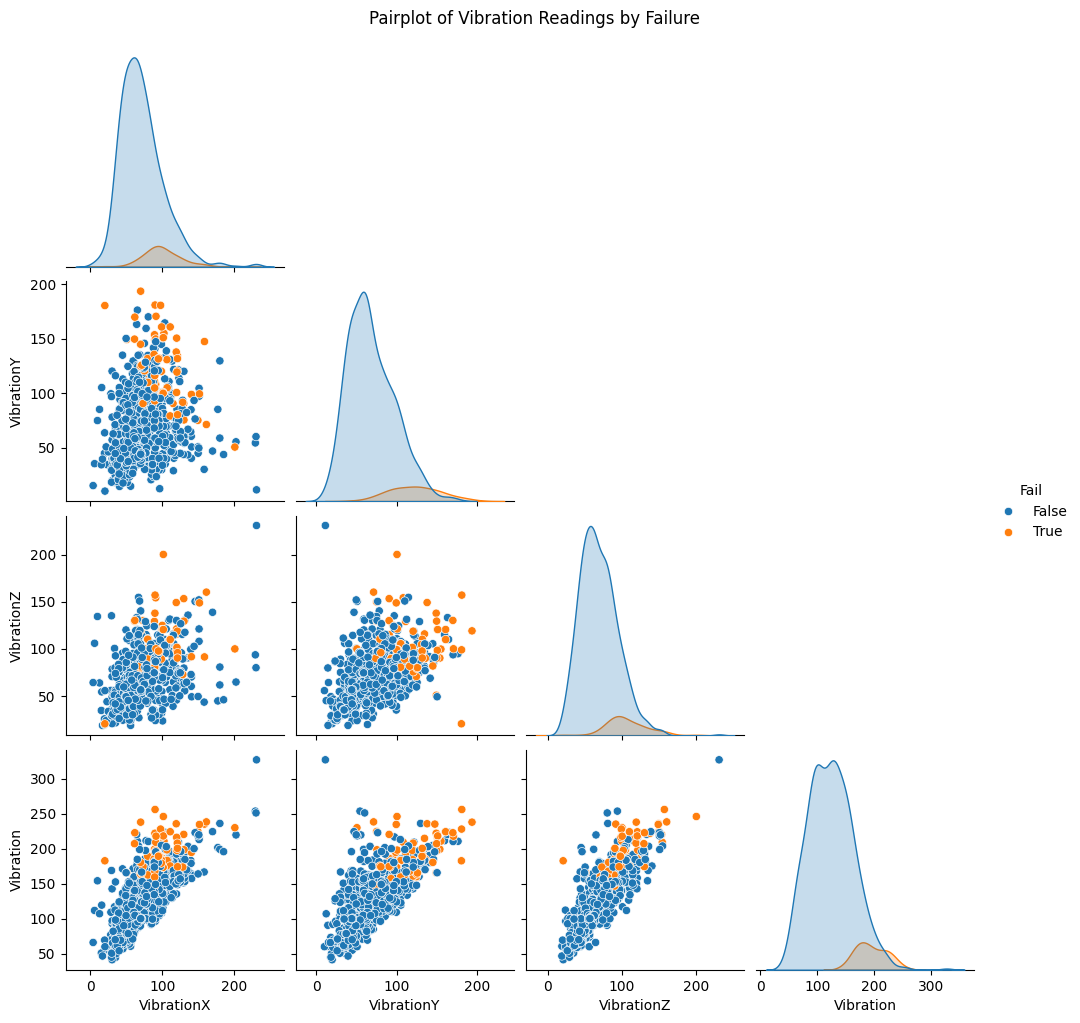

In [246]:
sns.pairplot(df, vars=['VibrationX', 'VibrationY', 'VibrationZ', 'Vibration'], hue='Fail', corner=True)
plt.suptitle("Pairplot of Vibration Readings by Failure", y=1.02)
plt.show()

Even with a single feature indicating the total vibration intensity of the equipment, **it may be still relevant to look at the vibration along the Y axis**, which shows a behavior more prone to failures than the other axes. In order to dedice whether the three vibration axes are being kept as features, I'll check if there is collinearity between vibration and each of its axes.

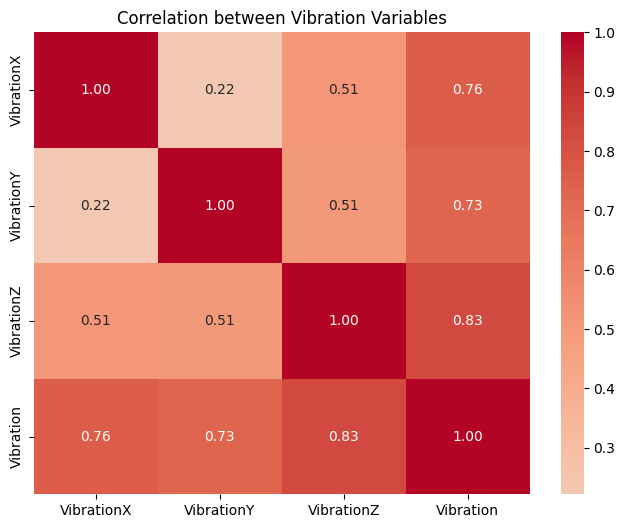

In [250]:
# Picking the columns related to vibration and calculating the correlation matrix
cols_vibration = ['VibrationX', 'VibrationY', 'VibrationZ', 'Vibration']
corr = df[cols_vibration].corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation between Vibration Variables')
plt.show()


The strongest correlations are exactly between Vibration and each axis. Therefore, this creates a favorable scenario for **removing the vibration axes from the model** to avoid collinearity.

Now, looking at the other readings, the objective is to check if any reading has good enough predictive power or if a new feature is needed.

<Axes: title={'center': 'Vibration'}, xlabel='Vibration', ylabel='Count'>

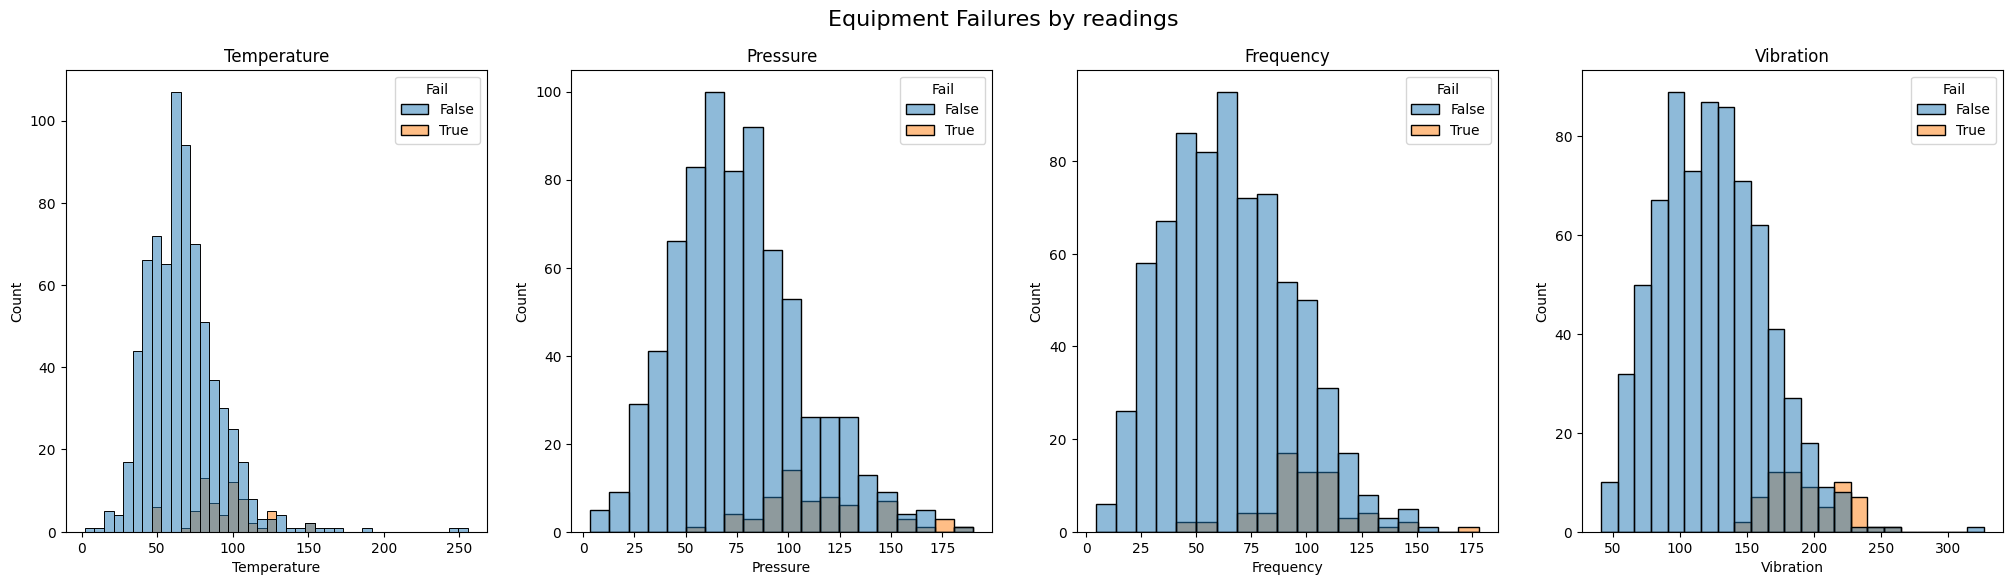

In [123]:
figure, axes = plt.subplots(1, 4,figsize=(25, 6))
figure.suptitle('Equipment Failures by readings', fontsize=16)
axes[0].set_title('Temperature')
axes[1].set_title('Pressure')
axes[2].set_title('Frequency')
axes[3].set_title('Vibration')

sns.histplot(data = df, x = 'Temperature', hue = 'Fail', ax = axes[0])
sns.histplot(data = df, x = 'Pressure', hue = 'Fail', ax = axes[1])
sns.histplot(data = df, x = 'Frequency', hue = 'Fail', ax = axes[2])
sns.histplot(data = df, x = 'Vibration', hue = 'Fail', ax = axes[3])

Looking at the individual histograms of temperature, pressure, frequency and vibration, it's possible to observe that higher values are more likely to result in a failure. But there are high readings in a non-failure state.

Only vibrations presents higher values with more failure concentration. Which may point to **a better predictive power than other variables.**

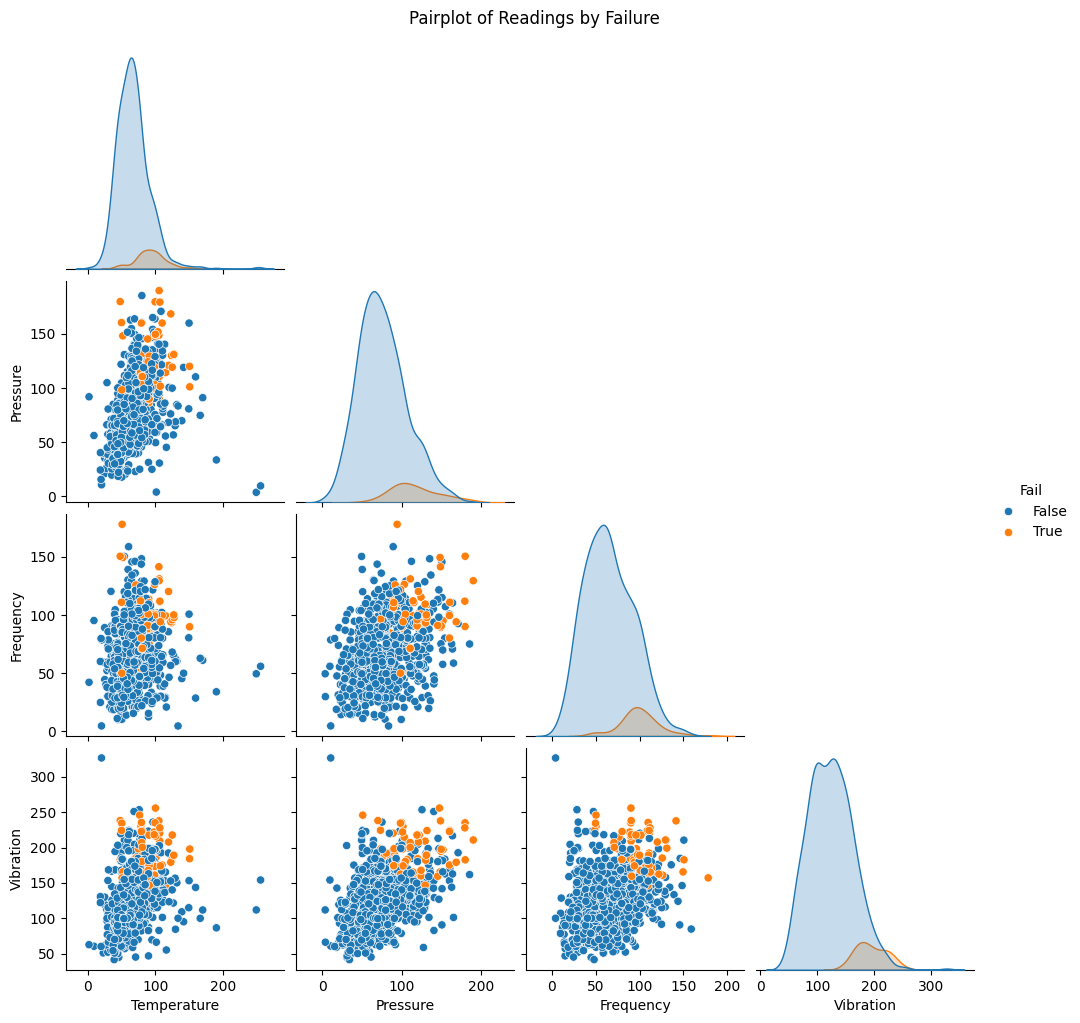

In [124]:
sns.pairplot(df, vars=['Temperature', 'Pressure', 'Frequency', 'Vibration'], hue='Fail', corner=True)
plt.suptitle("Pairplot of Readings by Failure", y=1.02)
plt.show()


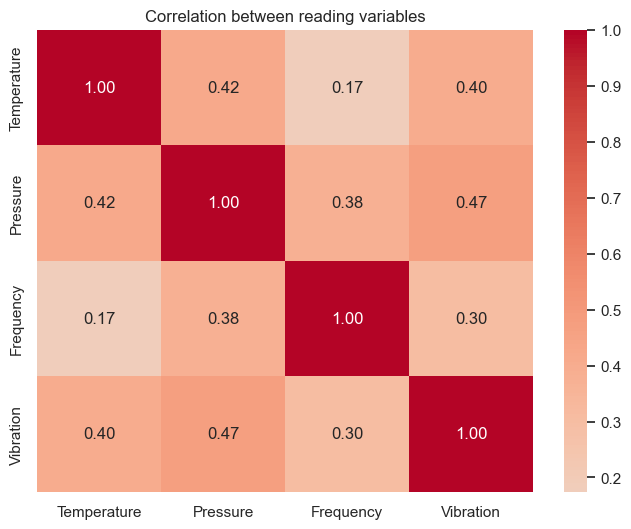

In [274]:
# Picking the columns related to readings and calculating the correlation matrix
cols_vibration = ['Temperature', 'Pressure', 'Frequency', 'Vibration']
corr = df[cols_vibration].corr(numeric_only=True)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation between reading variables')
plt.show()


The behavior of the features as a group tends to concentrate at high values, but the concern is that failure readings are not isolated from readings where there is no failure. Only with vibration and frequency is it possible to observe a "cleaner" separation, although there are still non-failure readings in the same region.

The correlation between all the readings shows a low to medium level of correlation, pointing that each reading has it's own value when explaining the target feature. But i want to highlight the biggest correlation between these variables, Pressure and Vibration, with 0.47. I'll test how the model will behave without one of them.

Now that we took a look into the readings, I would like to bring a preset analysis back, to check if a preset is capable of control other variables and let the machine to operate at higher readings of temperature, pressure or frequency. Maybe one specific preset makes the equipment heat more, or maybe have a higher frequency to boost productivity and that could lead to a failure.

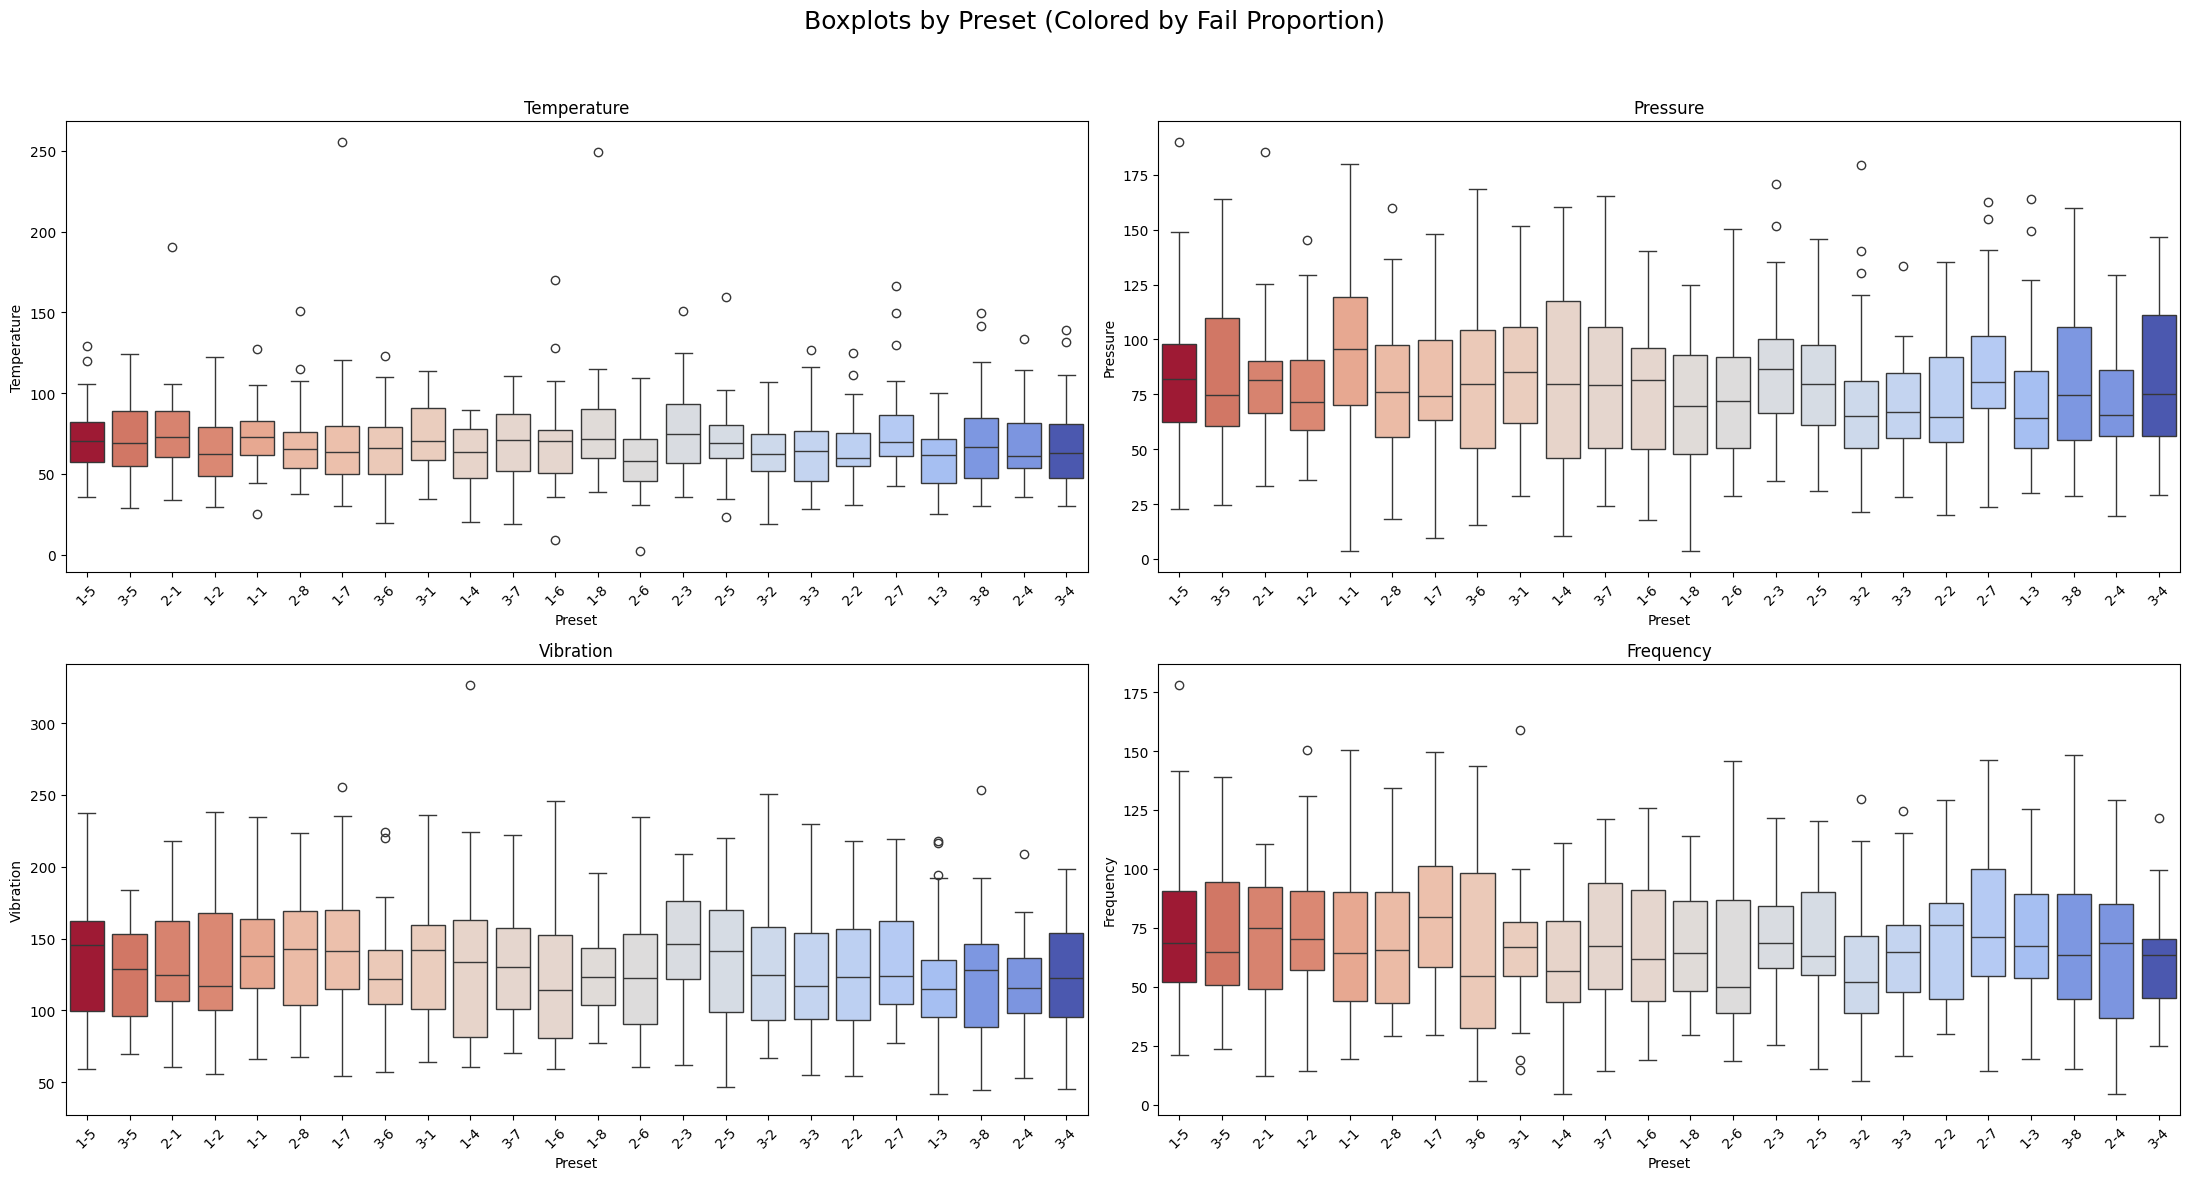

In [ ]:
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import warnings
warnings.filterwarnings('ignore')

# Normalize the fail proportion for coloring
norm = Normalize(vmin=result['fail_proportion'].min(), vmax=result['fail_proportion'].max())
cmap = get_cmap('coolwarm')
preset_color_map = {
    row['Preset']: cmap(norm(row['fail_proportion'])) for _, row in result.iterrows()
}

# Plotting boxplots for each variable colored by preset's fail proportion
fig, axes = plt.subplots(2, 2, figsize=(22, 12))
fig.suptitle("Boxplots by Preset (Colored by Fail Proportion)", fontsize=18)

variables = ['Temperature', 'Pressure', 'Vibration', 'Frequency']
positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for var, (i, j) in zip(variables, positions):
    ax = axes[i][j]
    sns.boxplot(
        data=df,
        x='Preset',
        y=var,
        ax=ax,
        palette=preset_color_map,
        order=result['Preset']  # ensures consistent order
    )
    ax.set_title(f"{var}")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The presets are colored with the failure rate previously calculated. These presets with higher failure rate doesn't appear to have a different behavior from other presets, neither more outliers, neither higher median, which indicates that the presets have their own predictive characteristics separate from the readings.

I will use Eta² as a last resort, a statistic that quantifies how much of the total variability in a dependent variable is explained by an independent categorical variable.

In [237]:
def eta_squared(df, cat_col, cont_col):
    groups = df.groupby(cat_col)[cont_col]
    means = groups.mean()
    counts = groups.count()
    overall_mean = df[cont_col].mean()

    ss_between = sum(counts * (means - overall_mean)**2)
    ss_total = sum((df[cont_col] - overall_mean)**2)

    return ss_between / ss_total

# Aplicar para cada variável contínua
for col in ['Temperature', 'Pressure', 'Vibration', 'Frequency']:
    eta2 = eta_squared(df, 'Preset', col)
    print(f"Eta² between Preset and {col}: {eta2:.3f}")

Eta² between Preset and Temperature: 0.039
Eta² between Preset and Pressure: 0.034
Eta² between Preset and Vibration: 0.033
Eta² between Preset and Frequency: 0.025


For independent features, Eta² is expected to be close to zero, as the results above suggest. This is a strong indicative that **preset has no meaningful explanatory power over the other sensor readings.**

## Predictive Maintenance

In order to train a model capable of predicting a failure before it actually occurs, it is necessary to create new features that capture patterns leading up to the failure event. Instead of simply detecting when the equipment is already in failure state, the goa is to identify early warning signs.

To support this, I will build a new set of shifted target features, where the failure signal is moved *n* cycles earlier, labeling data points that happened prior to the failure. For example, if a failure happens at cycle 100, shifting the failure label back by 5 cycles means cycles 95 to 99 will be treated as "pre-failure" — allowing the model to learn from data that precedes the issue.

To calculate the value of *n*, I'll do a brief time series analysis using two functions called Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).



Below I'll prepare what would be a set of new target features. But before shifting the failure *n* cycles, it's important to know how many cycles are statiscally relevant for each reading when plotting the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF), since cycle is a time-series.

- ACF measures how correlated a time series is with its own past values over different lags (cycles). It is like asking: "If the vibration is high in this cycle, how similar was it yesterday, 2 days ago and 3 days ago, so on...?"
- PACF measures the direct correlation between a time series and its lagged versions, removing the influence of intermediate lags. It asks: "How much does the vibration from 3 cycles ago affect today, ignoring cycles of 1 and 2 days ago?

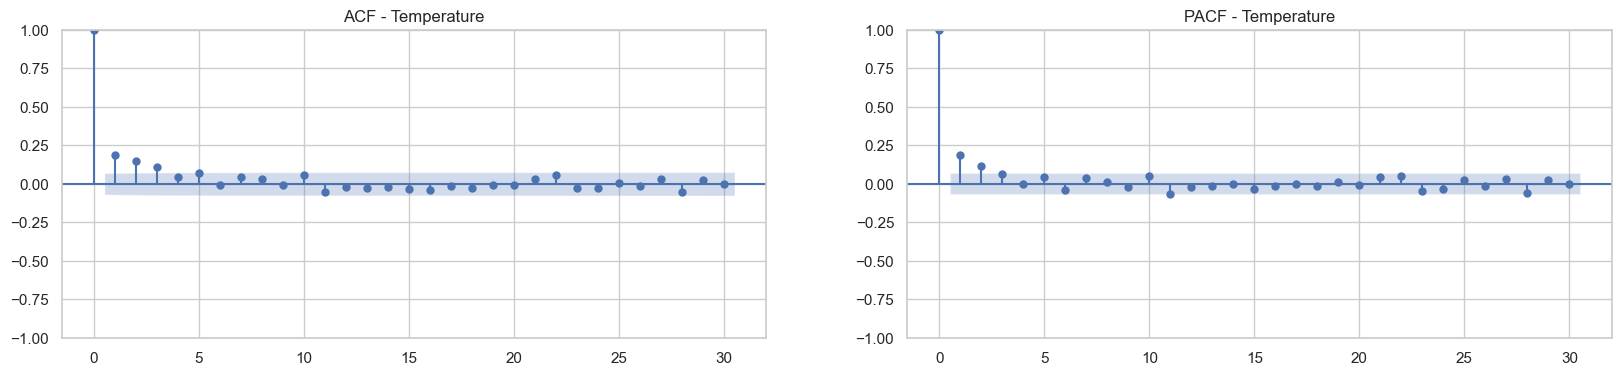

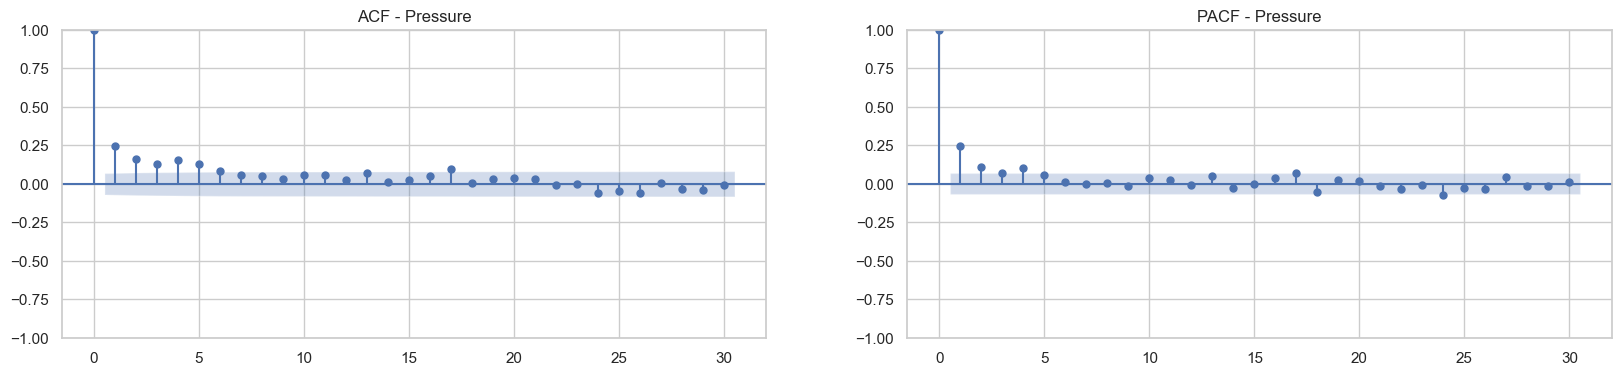

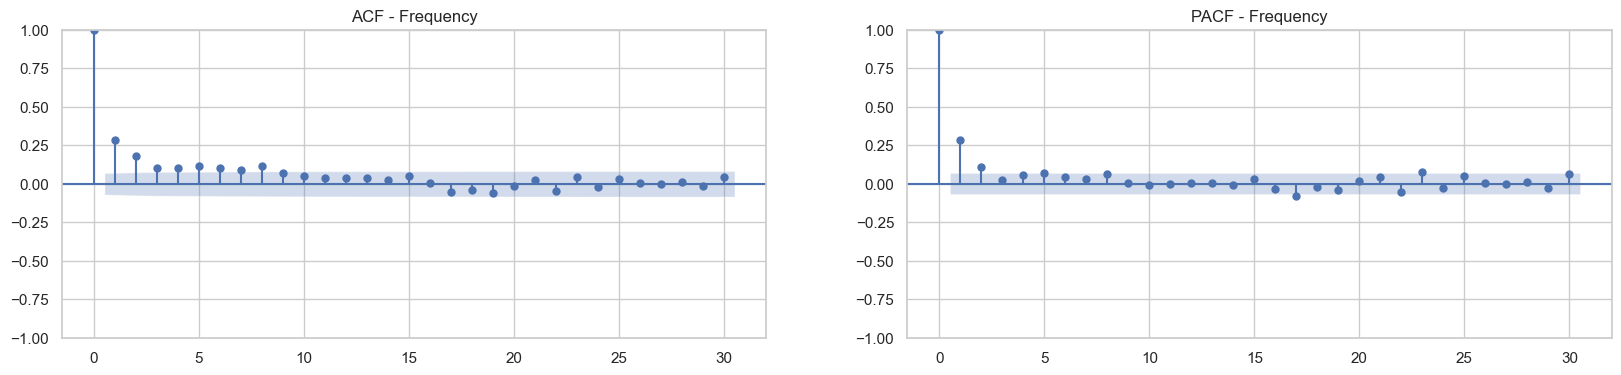

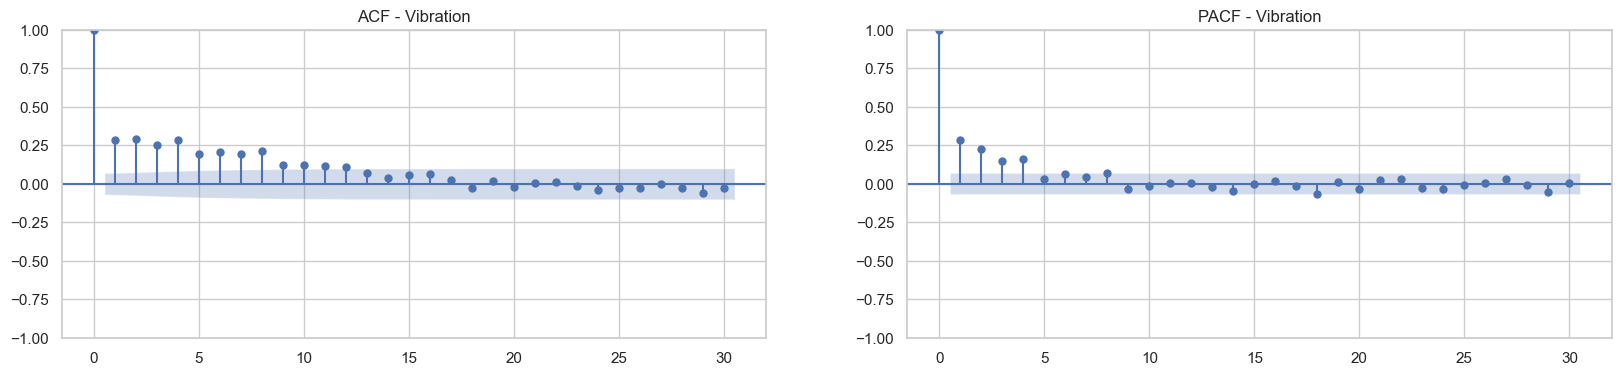

In [317]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for col in ['Temperature', 'Pressure', 'Frequency', 'Vibration']:
    series = df[col]
    fig, axes = plt.subplots(1, 2, figsize = (20, 4))
    plot_acf(series, lags = 30, ax = axes[0])
    axes[0].set_title(f'ACF - {col}')
    plot_pacf(series, lags = 30, ax = axes[1])
    axes[1].set_title(f'PACF - {col}')
    plt.show()

The blue zone indicates the region where autocorrelation values are not statistically significant.

Based on the ACF and PACF analysis:
- Temperature shows influence from up to 3 past cycles, with a direct effect up to 2 cycles before.
- Pressure has a longer memory, with influence up to 5 cycles, but only 1 cycle has direct impact.
- Frequency has a stronger memory up to 2 cycles, after that the autocorrelation drops significantly.
- Vibration stands out, showing autocorrelation up to 8 cycles and direct influence from the last 4 cycles.

These results suggest that for predictive modeling, it's valuable to create lag features based on the last 1 to 8 cycles, depending on the variable. With that, **the model should be able to capture early patterns of failure**.

In [218]:
df["PreFail_1"] = df["Fail"].shift(-1).fillna(False)
df["PreFail_2"] = df["Fail"].shift(-2).fillna(False)
df["PreFail_3"] = df["Fail"].shift(-3).fillna(False)

C:\Users\matbo\AppData\Local\Temp\ipykernel_1712\2796786603.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["PreFail_1"] = df["Fail"].shift(-1).fillna(False)
C:\Users\matbo\AppData\Local\Temp\ipykernel_1712\2796786603.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["PreFail_2"] = df["Fail"].shift(-2).fillna(False)
C:\Users\matbo\AppData\Local\Temp\ipykernel_1712\2796786603.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) i

The feature FirstFail will indicate if the fail is the first one in a sequence of failures.

In [176]:
df['FirstFail'] = (df['Fail'].shift(-1) == True) & (df['Fail'] == True) & (df['Fail'].shift(1) == False)

In [222]:
df['Temperature_diff'] = df['Temperature'].diff()

In [223]:
df[['Cycle', 'Temperature', 'Temperature_diff']]

,Cycle,Temperature,Temperature_diff
0,1,44.235186,NaN
1,2,60.807234,16.572049
2,3,79.027536,18.220301
3,4,79.716242,0.688706
4,5,39.989054,-39.727187
...,...,...,...
795,796,50.469522,-56.983353
796,797,49.985270,-0.484252
797,798,79.777294,29.792024
798,799,79.360314,-0.416981


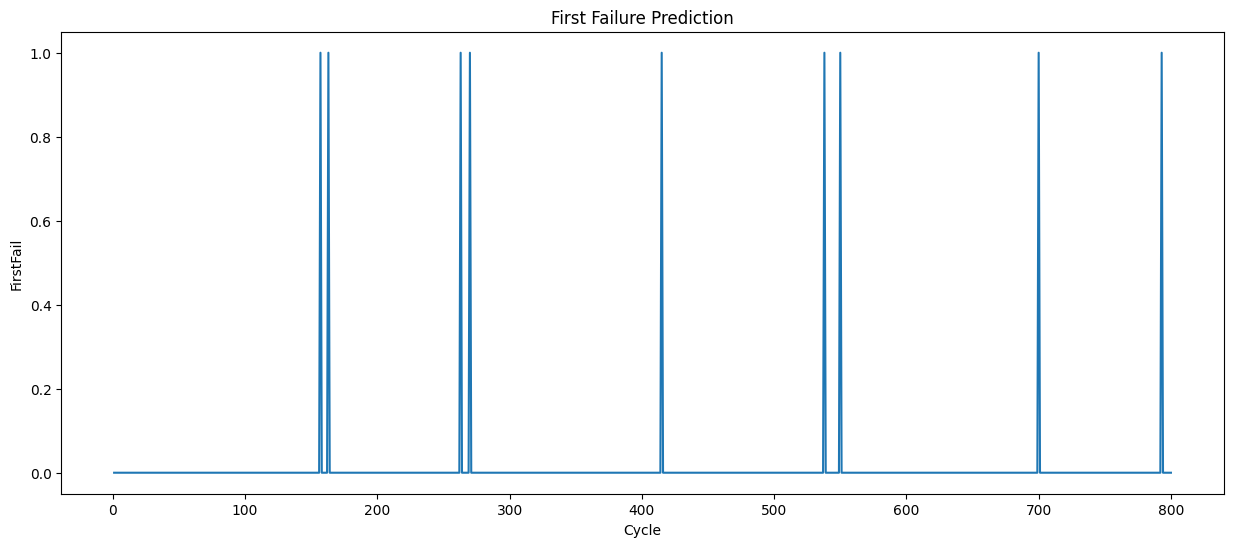

In [189]:
plt.figure(figsize=(15, 6))
sns.lineplot(data = df, x = 'Cycle', y = 'FirstFail')
plt.title('First Failure Prediction')
plt.show()

# Model

# Draft

## Entropy attempt

In [116]:
from scipy.stats import entropy

def shannon_entropy_window(values, bins=10):
    hist, _ = np.histogram(values, bins=bins, density=True)
    hist = hist[hist > 0]  # remover zero para evitar log(0)
    return entropy(hist)

window_size = 10  # tamanho da janela temporal (ex: 10 ciclos)
df['Entropy_Vib'] = df['Vibration'].rolling(window=window_size).apply(
    lambda x: shannon_entropy_window(x), raw=True
)
df['Entropy_T'] = df['Temperature'].rolling(window=window_size).apply(
    lambda x: shannon_entropy_window(x), raw=True
)
df['Entropy_P'] = df['Pressure'].rolling(window=window_size).apply(
    lambda x: shannon_entropy_window(x), raw=True
)


In [260]:
window_size = 10
entropies = []

def joint_entropy_window(*cols, bins=5):
    data = np.stack(cols, axis=1)  # shape (window_size, num_variables)
    hist, _ = np.histogramdd(data, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist.ravel())  # flatten para aplicar a entropia

# Para cada linha, pega uma janela das 4 colunas
for i in range(len(df)):
    if i < window_size - 1:
        entropies.append(np.nan)
        continue
    window = df.iloc[i - window_size + 1:i+1][['Vibration', 'Temperature', 'Pressure', 'Frequency']].values
    entropies.append(joint_entropy_window(*window.T))  # transpor para separar colunas

df['Entropy_All'] = entropies

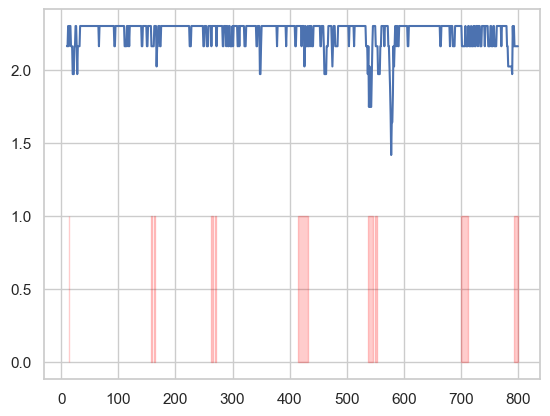

In [261]:
plt.plot(df['Cycle'], df['Entropy_All'], label='Entropy_All')
plt.fill_between(df['Cycle'], 0, 1, where=df['Fail'], color='red', alpha=0.2, label='Failure')


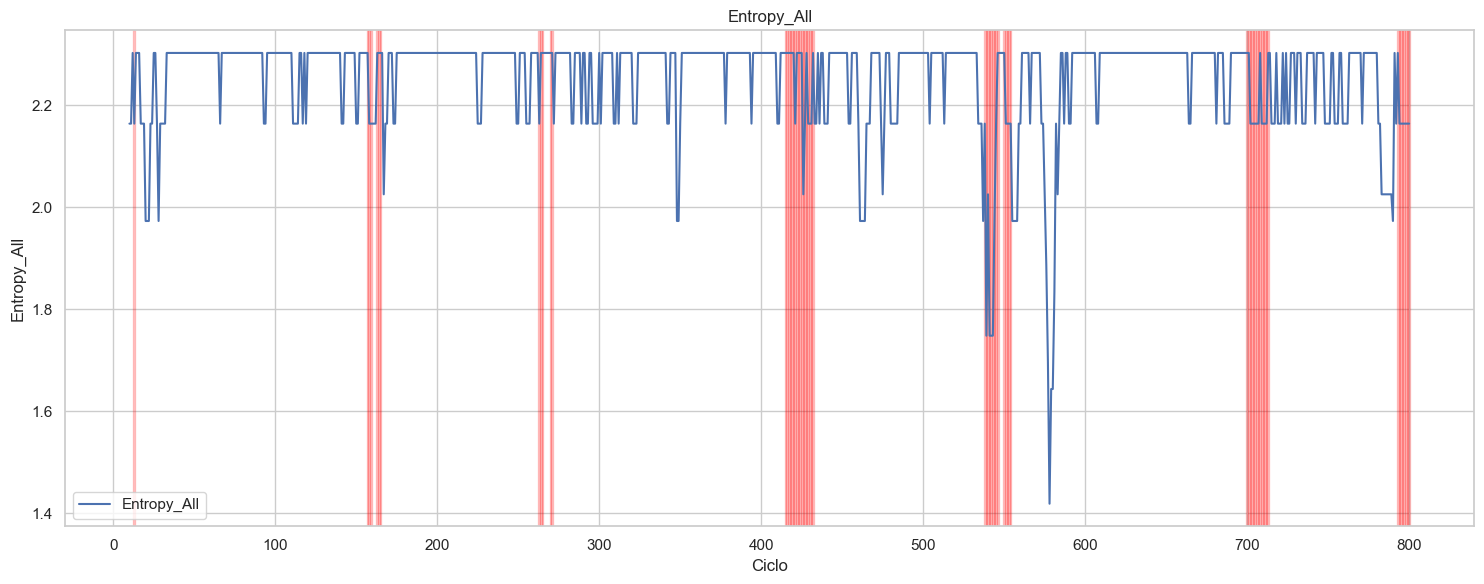

In [262]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='Cycle', y='Entropy_All', label='Entropy_All')

# Adiciona fundo vermelho onde há falha
for _, row in df[df['Fail']].iterrows():
    plt.axvspan(row['Cycle'] - 0.5, row['Cycle'] + 0.5, color='red', alpha=0.2)

plt.title('Entropy_All')
plt.xlabel('Ciclo')
plt.ylabel('Entropy_All')
plt.grid(True)
plt.tight_layout()
plt.show()


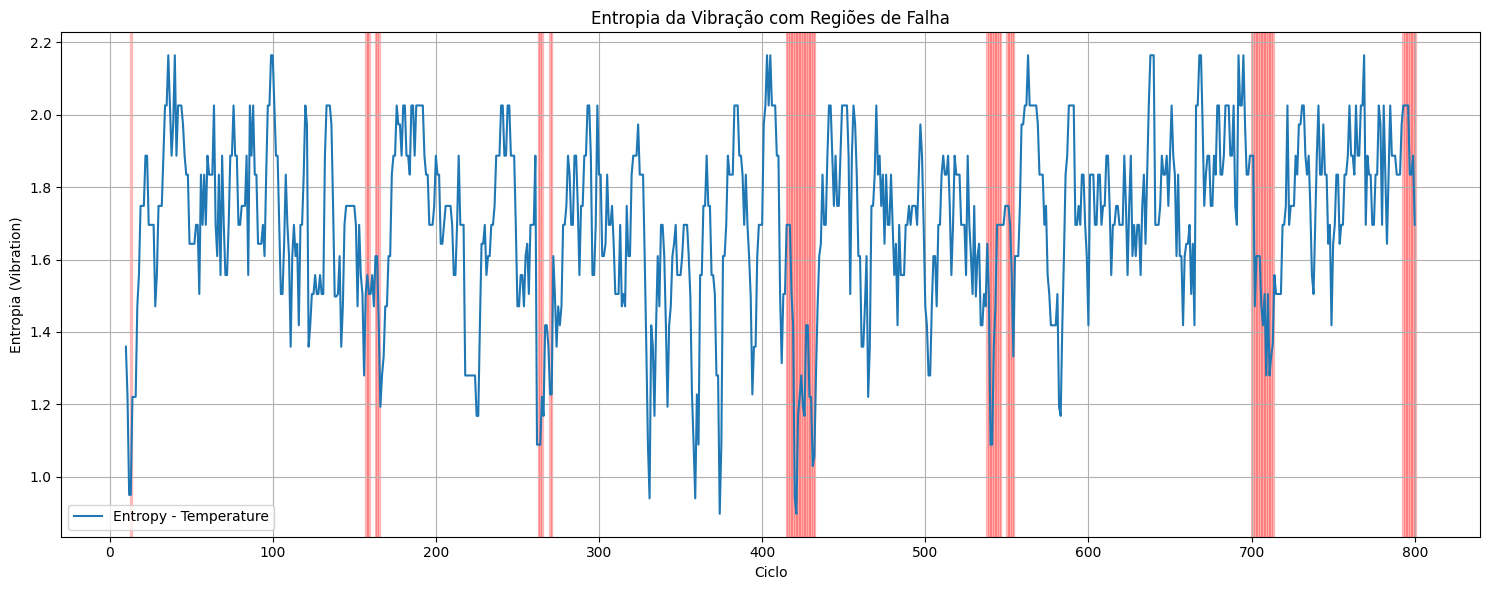

In [118]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='Cycle', y='Entropy_T', label='Entropy - Temperature')

# Adiciona fundo vermelho onde há falha
for _, row in df[df['Fail']].iterrows():
    plt.axvspan(row['Cycle'] - 0.5, row['Cycle'] + 0.5, color='red', alpha=0.2)

plt.title('Entropia da Vibração com Regiões de Falha')
plt.xlabel('Ciclo')
plt.ylabel('Entropia (Vibration)')
plt.grid(True)
plt.tight_layout()
plt.show()


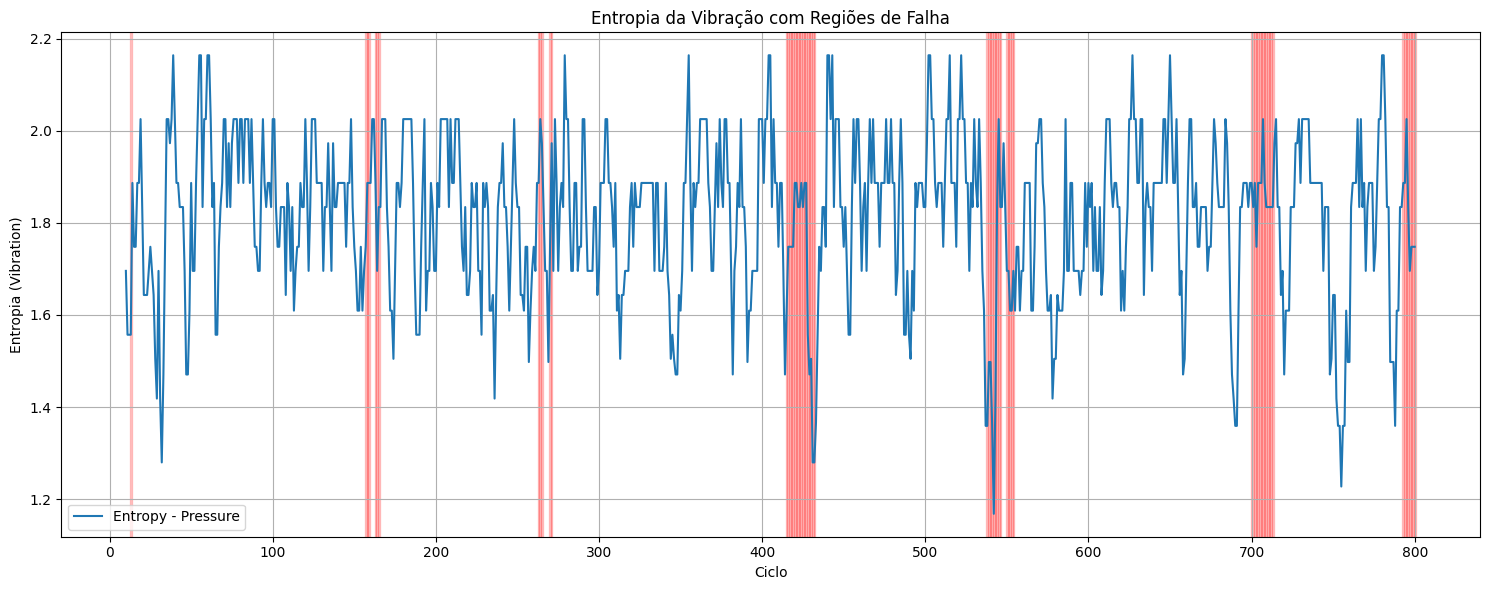

In [119]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=df, x='Cycle', y='Entropy_P', label='Entropy - Pressure')

# Adiciona fundo vermelho onde há falha
for _, row in df[df['Fail']].iterrows():
    plt.axvspan(row['Cycle'] - 0.5, row['Cycle'] + 0.5, color='red', alpha=0.2)

plt.title('Entropia da Vibração com Regiões de Falha')
plt.xlabel('Ciclo')
plt.ylabel('Entropia (Vibration)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Risk Score attempt

<Axes: xlabel='risk_score', ylabel='Count'>

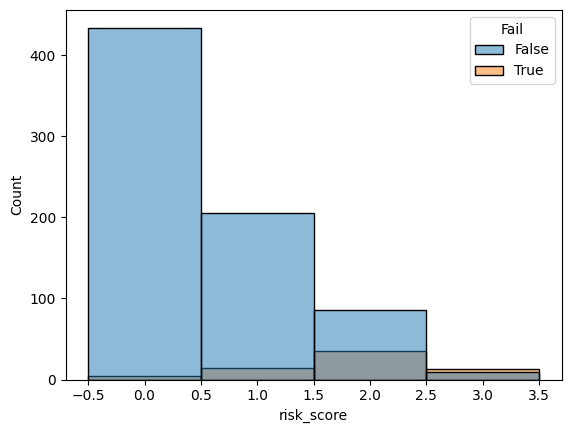

In [127]:
df['risk_score'] = (
    (df['Temperature'] > 80).astype(int) +
    (df['Pressure'] > 100).astype(int) +
    (df['Frequency'] > 100).astype(int)
)

# Exemplo: risco combinado = número de variáveis acima do limiar

sns.histplot(data=df, x='risk_score', hue='Fail', discrete=True)



## First fail target attempt

In [184]:
df[~((df['Fail'] == True) & (df['FirstFail'] == False))][['Cycle', 'Preset', 'Temperature', 'Pressure', 'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Vibration']]

,Cycle,Preset,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Vibration
0,1,3-6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,103.801329
1,2,2-4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,130.232621
2,3,2-1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,161.994313
3,4,2-3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,209.236814
4,5,2-5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,90.029176
...,...,...,...,...,...,...,...,...,...
788,789,3-2,53.550958,69.756841,86.434752,34.537847,35.164659,29.083565,99.500666
789,790,2-3,95.545013,116.444262,185.134217,43.649276,46.005316,25.454444,195.694728
790,791,3-7,39.909918,29.797831,34.575632,44.560622,41.588444,53.584668,70.076544
791,792,2-7,84.990752,70.507201,78.673752,96.382638,79.131822,121.850581,147.448355


In [182]:
df[~((df['Fail'] == True) & (df['FirstFail'] == False))]

,Cycle,Preset_1,Preset_2,Temperature,Pressure,VibrationX,VibrationY,VibrationZ,Frequency,Fail,Preset,Vibration,risk_score,Entropy_Vib,Entropy_T,Entropy_P,FirstFail
0,1,3,6,44.235186,47.657254,46.441769,64.820327,66.454520,44.483250,False,3-6,103.801329,0,NaN,NaN,NaN,False
1,2,2,4,60.807234,63.172076,62.005951,80.714431,81.246405,60.228715,False,2-4,130.232621,0,NaN,NaN,NaN,False
2,3,2,1,79.027536,83.032190,82.642110,98.254386,98.785196,80.993479,False,2-1,161.994313,0,NaN,NaN,NaN,False
3,4,2,3,79.716242,100.508634,122.362321,121.363429,118.652538,80.315567,False,2-3,209.236814,1,NaN,NaN,NaN,False
4,5,2,5,39.989054,51.764833,42.514302,61.037910,50.716469,64.245166,False,2-5,90.029176,0,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
788,789,3,2,53.550958,69.756841,86.434752,34.537847,35.164659,29.083565,False,3-2,99.500666,0,0.943348,1.834372,1.609438,False
789,790,2,3,95.545013,116.444262,185.134217,43.649276,46.005316,25.454444,False,2-3,195.694728,2,0.943348,1.834372,1.609438,False
790,791,3,7,39.909918,29.797831,34.575632,44.560622,41.588444,53.584668,False,3-7,70.076544,0,1.193550,1.834372,1.834372,False
791,792,2,7,84.990752,70.507201,78.673752,96.382638,79.131822,121.850581,False,2-7,147.448355,2,1.168282,1.973001,1.834372,False


## Feature interation attempt

In [292]:
df['PxV'] = df['Pressure']*df['Vibration']
df['PxT'] = df['Pressure']*df['Temperature']


## Pipeline 1

In [319]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold

# Preparing the data for modeling
# x_1 = df[['Preset', 'Temperature', 'Frequency', 'Vibration']] # 0.6638
# x_1 = df[['Preset', 'Temperature', 'Pressure', 'Frequency', 'Vibration']] # 0.64
x_1 = df[['Preset', 'Vibration', 'Frequency', 'PxT']] # 0.6156
y_1 = df["Fail"].astype('int')
# y_1 = df["PreFail_2"].astype('int')

# Separating categorical and numeric features for preprocessing
categorical_features = ['Preset']
# numeric_features = ['Temperature', 'Frequency', 'Vibration'] # 0.6638
# numeric_features = ['Temperature', 'Pressure', 'Frequency', 'Vibration'] # 0.64
numeric_features = ['Vibration', 'Frequency', 'PxT'] # 0.6156

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features)
    ],
    remainder='drop'
)

# Setting up the pipeline

pipeline_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=10))
])

# Splitting the data for time series cross-validation
# split = TimeSeriesSplit(n_splits=5)
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Cross validation
scores = cross_val_score(pipeline_1, x_1, y_1, cv=split, scoring='f1')

print("f1 for each split: ", scores)
print("f1 mean: ", scores.mean())

f1 for each split:  [0.52173913 0.60869565 0.64       0.61538462 0.69230769]
f1 mean:  0.6156254180602007


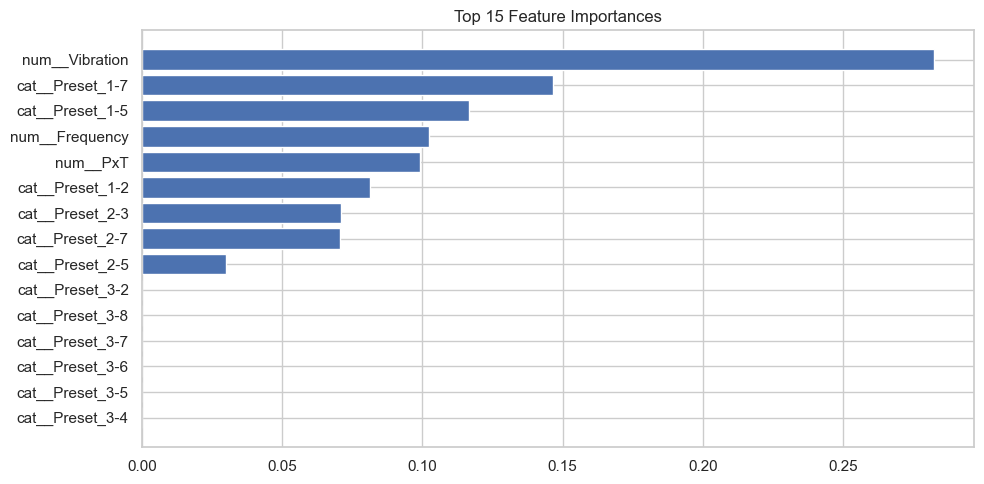

In [320]:
# Treinando o modelo com todo o conjunto (após validação cruzada)
pipeline_1.fit(x_1, y_1)

# Pegando o classificador treinado
model = pipeline_1.named_steps['classifier']

# Pegando os nomes das features após o OneHotEncoding
feature_names = pipeline_1.named_steps['preprocessor'].get_feature_names_out()

# Pegando as importâncias
importances = model.feature_importances_

# Empacotando em DataFrame
feat_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 5))
plt.barh(feat_importance_df['Feature'][:15], feat_importance_df['Importance'][:15])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()



## Pipeline 2

In [316]:
lag_map = {
    'Temperature': [1, 2, 3],
    'Pressure': [1, 2, 3, 4, 5],
    'Frequency': [1, 2],
    'Vibration': [1, 2, 3, 4, 5, 6, 7, 8]
}

for var, lags in lag_map.items():
    for l in lags:
        df[f'{var}_lag{l}'] = df[var].shift(l)


window_map = {
    'Temperature': 3,
    'Pressure': 5,
    'Frequency': 2,
    'Vibration': 8
}

for var, window in window_map.items():
    df[f'{var}_roll_mean'] = df[var].shift(1).rolling(window).mean()
    df[f'{var}_roll_std'] = df[var].shift(1).rolling(window).std()
    df[f'{var}_roll_min'] = df[var].shift(1).rolling(window).min()
    df[f'{var}_roll_max'] = df[var].shift(1).rolling(window).max()
    df[f'{var}_diff'] = df[var] - df[var].shift(1)

df['PreFail_8'] = df['Fail'].shift(-8).fillna(False)
df['PreFail_7'] = df['Fail'].shift(-7).fillna(False)
df['PreFail_6'] = df['Fail'].shift(-6).fillna(False)
df['PreFail_5'] = df['Fail'].shift(-5).fillna(False)
df['PreFail_4'] = df['Fail'].shift(-4).fillna(False)
df['PreFail_3'] = df['Fail'].shift(-3).fillna(False)
df['PreFail_2'] = df['Fail'].shift(-2).fillna(False)
df['PreFail_1'] = df['Fail'].shift(-1).fillna(False)

df_model = df.dropna(subset=[col for col in df.columns if 'lag' in col or 'roll' in col])

x_cols = [col for col in df_model.columns if any(key in col for key in ['lag', 'roll', 'diff'])]

x_model = df_model[x_cols]
y_model = df_model['PreFail_1'].astype(int)


pipeline_2 = Pipeline([
    ('classifier', XGBClassifier(random_state=10))
])

# Splitting the data for time series cross-validation
# split = TimeSeriesSplit(n_splits=5)
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Cross validation
scores = cross_val_score(pipeline_2, x_model, y_model, cv=split, scoring='f1')

print("f1 for each split: ", scores)
print("f1 mean: ", scores.mean())



f1 for each split:  [0.72727273 0.81481481 0.64       0.75       0.72727273]
f1 mean:  0.7318720538720539


## Pipeline 3

PreFail_4 mostrou ter o melhor custo-benefício

In [352]:
# Picking indices only when there's a failure
fail_idx = df.index[df['Fail'] == True]

# Assigning True to every range of pre-failure, from 1 to 8
for i in range(1,9):
    print(f'Calculating column Prefail_{i}')
    df[f'PreFail_{i}'] = False

    for idx in fail_idx:
        start_prefail = max(idx - i, 0) # The first cycle that will be flagged as pre-failure (can't be lower than 0)
        df.loc[start_prefail:idx - 1, f'PreFail_{i}'] = True



Calculating column Prefail_1
Calculating column Prefail_2
Calculating column Prefail_3
Calculating column Prefail_4
Calculating column Prefail_5
Calculating column Prefail_6
Calculating column Prefail_7
Calculating column Prefail_8


In [354]:
df.columns

Index(['Cycle', 'Preset_1', 'Preset_2', 'Temperature', 'Pressure',
       'VibrationX', 'VibrationY', 'VibrationZ', 'Frequency', 'Fail', 'Preset',
       'Vibration', 'risk_score', 'Entropy_Vib', 'Entropy_T', 'Entropy_P',
       'FirstFail', 'PreFail_1', 'PreFail_2', 'PreFail_3', 'Temperature_diff',
       'Entropy_All', 'Harmonic_Mean', 'PxV', 'PxT', 'Temperature_lag1',
       'Temperature_lag2', 'Temperature_lag3', 'Pressure_lag1',
       'Pressure_lag2', 'Pressure_lag3', 'Pressure_lag4', 'Pressure_lag5',
       'Frequency_lag1', 'Frequency_lag2', 'Vibration_lag1', 'Vibration_lag2',
       'Vibration_lag3', 'Vibration_lag4', 'Vibration_lag5', 'Vibration_lag6',
       'Vibration_lag7', 'Vibration_lag8', 'Temperature_roll_mean',
       'Temperature_roll_std', 'Temperature_roll_min', 'Temperature_roll_max',
       'Pressure_roll_mean', 'Pressure_roll_std', 'Pressure_roll_min',
       'Pressure_roll_max', 'Pressure_diff', 'Frequency_roll_mean',
       'Frequency_roll_std', 'Frequency_rol

In [362]:
lag_map = {
    'Temperature': [1, 2, 3],
    'Pressure': [1, 2, 3, 4, 5],
    'Frequency': [1, 2],
    'Vibration': [1, 2, 3, 4, 5, 6, 7, 8]
}

for var, lags in lag_map.items():
    for l in lags:
        df[f'{var}_lag{l}'] = df[var].shift(l)


window_map = {
    'Temperature': 3,
    'Pressure': 5,
    'Frequency': 2,
    'Vibration': 8
}

for var, window in window_map.items():
    df[f'{var}_roll_mean'] = df[var].shift(1).rolling(window).mean()
    df[f'{var}_roll_std'] = df[var].shift(1).rolling(window).std()
    df[f'{var}_roll_min'] = df[var].shift(1).rolling(window).min()
    df[f'{var}_roll_max'] = df[var].shift(1).rolling(window).max()
    df[f'{var}_diff'] = df[var] - df[var].shift(1)


df_model = df.dropna(subset=[col for col in df.columns if 'lag' in col or 'roll' in col])

x_cols = [col for col in df_model.columns if any(key in col for key in ['lag', 'roll', 'diff'])]

x_model = df_model[x_cols]
y_model = df_model['PreFail_4'].astype(int)


pipeline_2 = Pipeline([
    ('classifier', XGBClassifier(random_state=10))
])

# Splitting the data for time series cross-validation
# split = TimeSeriesSplit(n_splits=5)
split = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Cross validation
scores = cross_val_score(pipeline_2, x_model, y_model, cv=split, scoring='f1')

print("f1 for each split: ", scores)
print("f1 mean: ", scores.mean())



f1 for each split:  [0.64516129 0.78787879 0.68965517 0.625      0.85714286]
f1 mean:  0.7209676215516038
